#Google Colaboratoryを利用したmonotonic_selectionライブラリの使用例

Google Colaboratoryを利用すれば，簡単にPythonの実行環境を構築することができる．
ここでは，monotonic_selectionライブラリを用いて，包除積分モデルに二種類の単調性制約付き変数選択アルゴリズム（ステップワイズ法，Lasso回帰）をどのように適用するかを紹介する．

###Google driveをマウントし，monotonic_selectionライブラリをGoogle driveにダウンロードします．

In [1]:
!git clone https://github.com/AoiHonda-lab/IEI-Monotonic-Variable-Selection
%cd IEI-Monotonic-Variable-Selection

Cloning into 'IEI-Monotonic-Variable-Selection'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 10.99 KiB | 2.75 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/IEI-Monotonic-Variable-Selection


###必要なライブラリをインストールします．

In [2]:
!pip install ucimlrepo

###必要なライブラリをインポートします．

In [3]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from monotonic_selection import MonoStepwise, MonoLasso

###使用するデータセットをUCI機械学習リポジトリから取得します．

ここでは "Car Evaluation" データセットを使用する．このデータセットに含まれる説明変数および目的変数はすべてカテゴリ値となっているので，数値形式への変換とMin-Max正規化を用いた[0,1]へのスケーリングを行う．

In [4]:
car_evaluation = fetch_ucirepo(id=19)

df_features = pd.DataFrame(car_evaluation.data.features)
df_targets = pd.DataFrame(car_evaluation.data.targets)

df = pd.concat([df_targets, df_features], axis=1)

df['buying'] = df['buying'].map({'vhigh':1,'high':2,'med':3,'low':4})
df['maint'] = df['maint'].map({'vhigh':1,'high':2,'med':3,'low':4})
df['doors'] = df['doors'].map({'2':1,'3':2,'4':3,'5more':4})
df['persons'] = df['persons'].map({'2':1,'4':2,'more':3})
df['lug_boot'] = df['lug_boot'].map({'big':3,'med':2,'small':1})
df['safety'] = df['safety'].map({'high':3,'med':2,'low':1})
df['class'] = df['class'].map({'unacc':1,'acc':2,'good':3,'vgood':4})

df=df.apply(lambda x: (x-x.min())/(x.max()-x.min()))

X=df.drop(['class'],axis=1)
Y=df['class']

###データセットを4:1に学習データとテストデータに分割します．

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)

###学習モデルを作成します．（単調性制約付きステップワイズ法）

インポートしたMonoStepwiseクラスでモデルを生成する．

引数として，投入と除去の判断基準，最大繰り返し回数，加法性の指定，t-ノルム，ログを表示するかどうかを渡す．

投入と除去の判断基準は，分散比$F$，赤池情報量基準$AIC$，ベイズ情報量基準$BIC$の三つから指定する．

加法性の次数は1から説明変数の数までの整数を渡し，t-ノルムは論理積:min，代数積:algebraic，Dubois-Pradeのt-norm(λ=0.5):duboisを使用することができる．

引数を指定しない場合，デフォルトはそれぞれ，投入と除去の判断基準が分散比$F$，最大繰り返し回数1000回，完全非加法，論理積，ログ非表示となっている．

In [6]:
model_stepwise = MonoStepwise(criterion='bic',additivity_order=6, t_norm='algebraic',log_display=True)

###学習を実行します．

In [10]:
model_stepwise.fit(X_train,Y_train)

selection: buying-maint-persons-safety
selection: buying-persons-lug_boot-safety
selection: maint-doors-persons-safety
selection: maint-safety
selection: buying-persons-safety
selection: maint-persons-lug_boot-safety
selection: buying-doors-safety
selection: buying-lug_boot
converged!
time[s]: 3.76


###学習結果を表示します．

学習後の決定係数，選択された項を表示する．
また，パラメータから算出されたファジィ測度，相互作用指標，シャープレイ値も出力可能である．

In [11]:
#決定係数
print(f"r2 score: {model_stepwise.r2_score(X_test, Y_test)}")

r2 score: 0.7170116856851965


In [12]:
#選択された項
model_stepwise.selected_variables()

---------------------selected variables---------------------
buying-lug_boot: 0.041787999953026636
maint-safety: 0.0820737555835512
buying-doors-safety: 0.08751782012579451
buying-persons-safety: 0.2356502692023676
buying-maint-persons-safety: 0.3561077001506266
buying-persons-lug_boot-safety: 0.31292761918780343
maint-doors-persons-safety: 0.20458602454671015
maint-persons-lug_boot-safety: 0.3116047143539789
selected variables: 8/63
------------------------------------------------------------


['buying-lug_boot',
 'maint-safety',
 'buying-doors-safety',
 'buying-persons-safety',
 'buying-maint-persons-safety',
 'buying-persons-lug_boot-safety',
 'maint-doors-persons-safety',
 'maint-persons-lug_boot-safety']

In [13]:
#ファジィ測度
model_stepwise.fuzzy()

---------------------------fuzzy----------------------------
buying: 0.0
maint: 0.0
doors: 0.0
persons: 0.0
lug_boot: 0.0
safety: 0.0
buying-maint: 0.0
buying-doors: 0.0
buying-persons: 0.0
buying-lug_boot: 0.041787999953026636
buying-safety: 0.0
maint-doors: 0.0
maint-persons: 0.0
maint-lug_boot: 0.0
maint-safety: 0.0820737555835512
doors-persons: 0.0
doors-lug_boot: 0.0
doors-safety: 0.0
persons-lug_boot: 0.0
persons-safety: 0.0
lug_boot-safety: 0.0
buying-maint-doors: 0.0
buying-maint-persons: 0.0
buying-maint-lug_boot: 0.041787999953026636
buying-maint-safety: 0.0820737555835512
buying-doors-persons: 0.0
buying-doors-lug_boot: 0.041787999953026636
buying-doors-safety: 0.08751782012579451
buying-persons-lug_boot: 0.041787999953026636
buying-persons-safety: 0.2356502692023676
buying-lug_boot-safety: 0.041787999953026636
maint-doors-persons: 0.0
maint-doors-lug_boot: 0.0
maint-doors-safety: 0.0820737555835512
maint-persons-lug_boot: 0.0
maint-persons-safety: 0.0820737555835512
maint-l

In [14]:
#相互作用指標
model_stepwise.interaction()

------------------------interaction-------------------------
buying: 0.2958755262538415
maint: 0.2591114875546045
doors: 0.08031911284527571
persons: 0.3748566042939023
lug_boot: 0.17702708336195888
safety: 0.44506608879427606
buying-maint: 0.11870256671687553
buying-doors: 0.043758910062897255
buying-persons: 0.3408369077139938
buying-lug_boot: 0.14609720634896112
buying-safety: 0.384595817776891
maint-doors: 0.06819534151557005
maint-persons: 0.2907661463504385
maint-lug_boot: 0.10386823811799296
maint-safety: 0.37283990193398975
doors-persons: 0.06819534151557005
doors-lug_boot: 0.0
doors-safety: 0.1119542515784673
persons-lug_boot: 0.20817744451392742
persons-safety: 0.5129004873475568
lug_boot-safety: 0.20817744451392742
buying-maint-doors: 0.0
buying-maint-persons: 0.1780538500753133
buying-maint-lug_boot: 0.0
buying-maint-safety: 0.1780538500753133
buying-doors-persons: 0.0
buying-doors-lug_boot: 0.0
buying-doors-safety: 0.08751782012579451
buying-persons-lug_boot: 0.15646380959

--------------------------shapley---------------------------
buying: 0.2958755262538415
doors: 0.08031911284527571
lug_boot: 0.17702708336195888
maint: 0.2591114875546045
persons: 0.3748566042939023
safety: 0.44506608879427606
------------------------------------------------------------


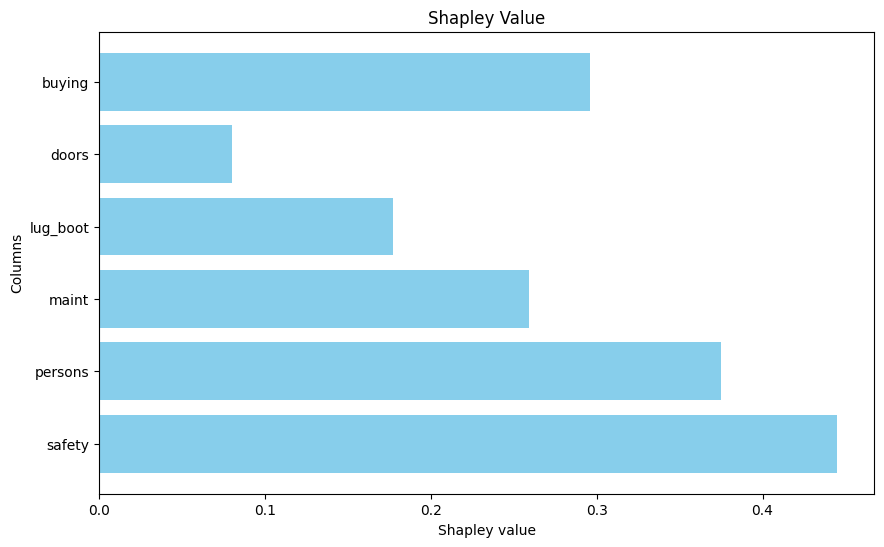

In [15]:
#シャープレイ値
model_stepwise.shapley_plot()

###学習モデルを作成します．（単調性制約付きLasso回帰）

インポートしたMonoLassoクラスでモデルを生成する．

引数として，L1正則化項のパラメータ，座標降下法の収束判定閾値，最大繰り返し回数，加法性の指定，t-ノルム，ログを表示するかどうかを渡す．

引数を指定しない場合，デフォルトはそれぞれ，L1正則化項のパラメータα=0.001，収束判定閾値$10^{-4}$，最大繰り返し回数1000回，完全非加法，論理積，ログ非表示となっている．

In [16]:
model_lasso=MonoLasso(alpha=0.001,additivity_order=6,t_norm='algebraic',log_display=True)

###学習を実行します．

In [17]:
model_lasso.fit(X_train,Y_train)

[1/1000], weight_change: 0.31350487660489373
[2/1000], weight_change: 0.20195774981192435
[3/1000], weight_change: 0.07979942900321406
[4/1000], weight_change: 0.041664611226028166
[5/1000], weight_change: 0.03143243676855733
[6/1000], weight_change: 0.024110952112838636
[7/1000], weight_change: 0.02068188802725861
[8/1000], weight_change: 0.021200215631008552
[9/1000], weight_change: 0.01886554261408988
[10/1000], weight_change: 0.017656446083464478
[11/1000], weight_change: 0.016768391927185596
[12/1000], weight_change: 0.015700017793939293
[13/1000], weight_change: 0.014994440971161295
[14/1000], weight_change: 0.015013661921551008
[15/1000], weight_change: 0.01334229016657368
[16/1000], weight_change: 0.01224949700275907
[17/1000], weight_change: 0.010423232696151726
[18/1000], weight_change: 0.00854206026258859
[19/1000], weight_change: 0.007935804527038983
[20/1000], weight_change: 0.0074766519792865025
[21/1000], weight_change: 0.006823023800334671
[22/1000], weight_change: 0.00

###学習結果を表示します．

単調性制約付きLasso回帰は学習曲線も表示することができる．

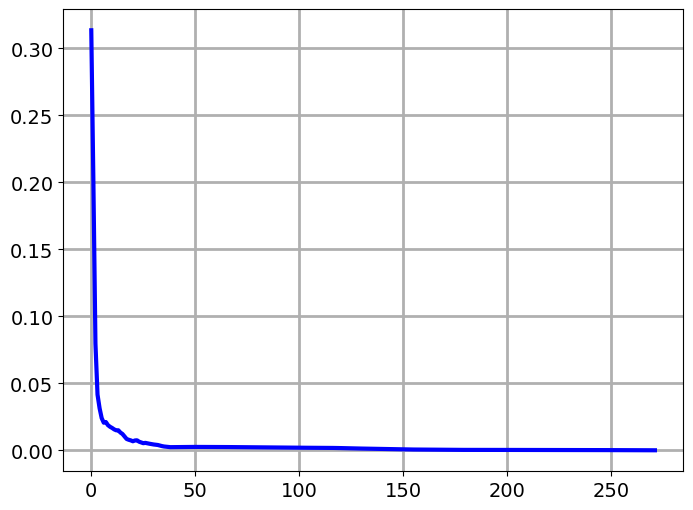

In [24]:
#学習曲線
model_lasso.plot_weight_change()

In [19]:
#決定係数
print(f"r2 score: {model_lasso.r2_score(X_test, Y_test)}")

r2 score: 0.7242411703871076


In [20]:
#選択された項
model_lasso.selected_variables()

---------------------selected variables---------------------
buying-doors: 0.008318253062700693
buying-lug_boot: 0.007552028369375448
buying-safety: 0.054340554708757455
maint-doors: 0.001366052499772332
maint-lug_boot: 0.0032747299303785035
maint-safety: 0.055588063176815264
buying-doors-safety: 0.011126115296491051
buying-persons-lug_boot: 0.012007169419047052
buying-persons-safety: 0.19019312816027237
buying-lug_boot-safety: 0.020659224332924064
maint-persons-lug_boot: 0.0623120420405886
maint-persons-safety: 0.1363797522238782
buying-maint-persons-safety: 0.22320844729574418
buying-maint-lug_boot-safety: 0.07454617110044079
buying-doors-persons-safety: 0.12102277779682655
buying-persons-lug_boot-safety: 0.27747915009787016
maint-doors-persons-safety: 0.10827658459766686
maint-persons-lug_boot-safety: 0.1593345403849396
buying-maint-persons-lug_boot-safety: 0.0028821068414672953
selected variables: 19/63
------------------------------------------------------------


['buying-doors',
 'buying-lug_boot',
 'buying-safety',
 'maint-doors',
 'maint-lug_boot',
 'maint-safety',
 'buying-doors-safety',
 'buying-persons-lug_boot',
 'buying-persons-safety',
 'buying-lug_boot-safety',
 'maint-persons-lug_boot',
 'maint-persons-safety',
 'buying-maint-persons-safety',
 'buying-maint-lug_boot-safety',
 'buying-doors-persons-safety',
 'buying-persons-lug_boot-safety',
 'maint-doors-persons-safety',
 'maint-persons-lug_boot-safety',
 'buying-maint-persons-lug_boot-safety']

In [21]:
#ファジィ測度
model_lasso.fuzzy()

---------------------------fuzzy----------------------------
buying: 0.0
maint: 0.0
doors: 0.0
persons: 0.0
lug_boot: 0.0
safety: 0.0
buying-maint: 0.0
buying-doors: 0.008318253062700693
buying-persons: 0.0
buying-lug_boot: 0.007552028369375448
buying-safety: 0.054340554708757455
maint-doors: 0.001366052499772332
maint-persons: 0.0
maint-lug_boot: 0.0032747299303785035
maint-safety: 0.055588063176815264
doors-persons: 0.0
doors-lug_boot: 0.0
doors-safety: 0.0
persons-lug_boot: 0.0
persons-safety: 0.0
lug_boot-safety: 0.0
buying-maint-doors: 0.009684305562473025
buying-maint-persons: 0.0
buying-maint-lug_boot: 0.010826758299753951
buying-maint-safety: 0.10992861788557272
buying-doors-persons: 0.008318253062700693
buying-doors-lug_boot: 0.015870281432076142
buying-doors-safety: 0.0737849230679492
buying-persons-lug_boot: 0.0195591977884225
buying-persons-safety: 0.24453368286902982
buying-lug_boot-safety: 0.08255180741105697
maint-doors-persons: 0.001366052499772332
maint-doors-lug_boot:

In [22]:
#相互作用指標
model_lasso.interaction()

------------------------interaction-------------------------
buying: 0.28774118841434215
maint: 0.23826287810462993
doors: 0.06587569847869021
persons: 0.3565374936928174
lug_boot: 0.16548924451150296
safety: 0.41596038813397374
buying-maint: 0.0999720661757618
buying-doors: 0.05422223664322173
buying-persons: 0.30905746723017347
buying-lug_boot: 0.14194752568849817
buying-safety: 0.39813583074426184
maint-doors: 0.037458247365661286
maint-persons: 0.26367294793538376
maint-lug_boot: 0.11311151482283308
maint-safety: 0.31295371379205167
doors-persons: 0.07643312079816446
doors-lug_boot: 0.0
doors-safety: 0.08199617844640998
persons-lug_boot: 0.18348469593445457
persons-safety: 0.4604474669601245
lug_boot-safety: 0.1815034260712457
buying-maint-doors: 0.0
buying-maint-persons: 0.11256492592836119
buying-maint-lug_boot: 0.03823378783070949
buying-maint-safety: 0.14983801147858158
buying-doors-persons: 0.060511388898413274
buying-doors-lug_boot: 0.0
buying-doors-safety: 0.0716375041949043

--------------------------shapley---------------------------
buying: 0.28774118841434215
doors: 0.06587569847869021
lug_boot: 0.16548924451150296
maint: 0.23826287810462993
persons: 0.3565374936928174
safety: 0.4159603881339738
------------------------------------------------------------


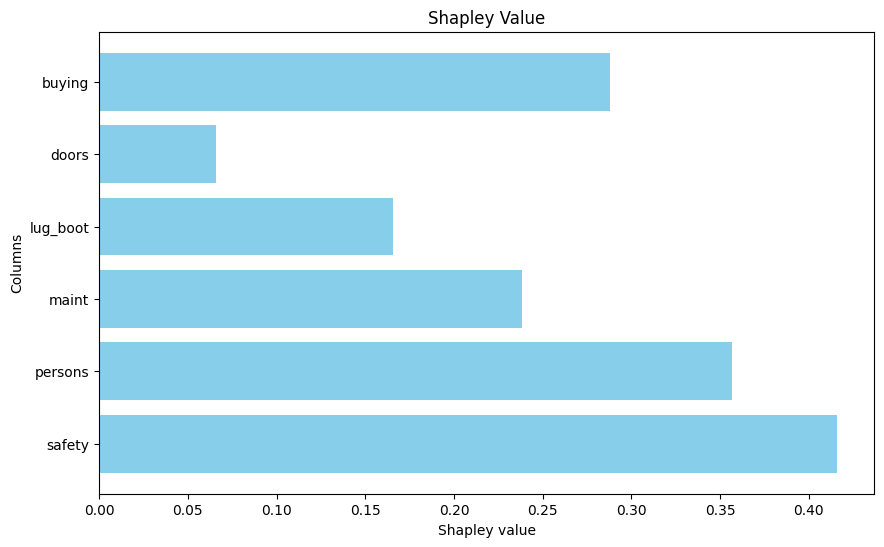

In [23]:
#シャープレイ値
model_lasso.shapley_plot()